In [0]:
import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
import random

In [0]:
data = pd.read_csv("data.csv")
dp = pd.read_csv("doipacs.csv")
cdata = pd.read_csv('cdata.csv')
cb = pd.read_csv("citationBara.csv")
cen = pd.read_csv("cen.csv")

# Analyses


## 1. Order of Author Analysis

In [0]:
aa = data[data['is_alpha'] == False]
print(len(aa))
print(aa['doi'].nunique())
aa.head()

252444
503297


,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI
1,10.1103/PhysRev.5.269,127898,male,3,3,True,False,1915,article,PR
2,10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI


In [0]:
aa_u = aa['id'].unique()
print(len(aa_u))

aa_m = aa[aa['gender'] == 'male']
print(aa_m['id'].nunique())

aa_fm = aa[aa['gender'] == 'female']
print(aa_fm['id'].nunique())

69578
59842
9736


In [0]:
first = aa[aa['order'] == 1]
print(len(first))

second = aa[aa['order'] == 2]
second = second[second['is_last'] == False]
print(len(second))

middle = aa[aa['order'] > 2]
middle = middle[middle['is_last'] == False]
print(len(middle))

last = aa[aa['order'] != 1]
last = last[last['is_last'] == True]
print(len(last))

149627
87869
115619
150182


In [0]:
first_m = first[first['gender'] == 'male']
print(len(first_m))

second_m = second[second['gender'] == 'male']
print(len(second_m))

middle_m = middle[middle['gender'] == 'male']
print(len(middle_m))

last_m = last[last['gender'] == 'male']
print(len(last_m))

137223
80073
104827
137412


In [0]:
first_fm = first[first['gender'] == 'female']
print(len(first_fm))

second_fm = second[second['gender'] == 'female']
print(len(second_fm))

middle_fm = middle[middle['gender'] == 'female']
print(len(middle_fm))

last_fm = last[last['gender'] == 'female']
print(len(last_fm))

12404
7796
10792
12770


In [0]:
print(len(first_m) / len(first))
print(len(second_m) / len(second))
print(len(middle_m) / len(middle))
print(len(last_m) / len(last))

0.9171005233012759
0.9112770146468038
0.9066589401395965
0.9149698365982608


In [0]:
print(len(first_fm) / len(first))
print(len(second_fm) / len(second))
print(len(middle_fm) / len(middle))
print(len(last_fm) / len(last))

0.08289947669872416
0.08872298535319624
0.09334105986040357
0.08503016340173922


In [0]:
print(first['id'].nunique())
print(second['id'].nunique())
print(middle['id'].nunique())
print(last['id'].nunique())

32827
27775
26557
32687


In [0]:
print(first_m['id'].nunique())
print(second_m['id'].nunique())
print(middle_m['id'].nunique())
print(last_m['id'].nunique())

28848
24494
23249
28643


In [0]:
print(first_fm['id'].nunique())
print(second_fm['id'].nunique())
print(middle_fm['id'].nunique())
print(last_fm['id'].nunique())

3979
3281
3308
4044


In [0]:
print(first_m['id'].nunique() / first['id'].nunique())
print(second_m['id'].nunique() / second['id'].nunique())
print(middle_m['id'].nunique() / middle['id'].nunique())
print(last_m['id'].nunique() / last['id'].nunique())

0.8787888019008743
0.8818721872187218
0.875437737696276
0.8762810903417261


In [0]:
print(first_fm['id'].nunique() / first['id'].nunique())
print(second_fm['id'].nunique() / second['id'].nunique())
print(middle_fm['id'].nunique() / middle['id'].nunique())
print(last_fm['id'].nunique() / last['id'].nunique())

0.12121119809912571
0.11812781278127812
0.12456226230372407
0.12371890965827394


In [0]:
del first
del second
del middle
del last
del first_m
del second_m
del middle_m
del last_m
del first_fm
del second_fm
del middle_fm
del last_fm

## 2'. Preliminary Productivity Graphs

(1.0, 2.0)

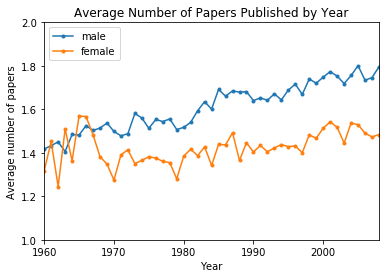

In [0]:
subdata = data.drop(['order','doi','numAuthor','is_last','is_alpha','articleType','journal'],axis=1)

hier_subdata = subdata.groupby(['gender', 'year']).count()
count_author = subdata.groupby(['gender', 'year'])['id'].nunique()

male = hier_subdata.xs('male')['id']/count_author.xs('male')
female = hier_subdata.xs('female')['id']/count_author.xs('female')

plt.figure(1)

male.plot(style ='.-')
female.plot(style='.-')

plt.legend(['male', 'female'], loc='upper left')
plt.title('Average Number of Papers Published by Year')
plt.xlabel('Year')
plt.ylabel('Average number of papers')
plt.xlim(xmin=1960, xmax=2008)
plt.ylim(1.0,2.0)

In [0]:
print(subdata.head())
print(len(subdata))

first_paper = {}

male_data = []
female_data = []

male_count = {}
female_count = {}

for idx, row in subdata.sort_values('year').iterrows():
  a_id = row['id']
  gender = row['gender']
  year = row['year']
  if a_id not in first_paper:
    first_paper[a_id] = year
    continue
  
  paper_age = year - first_paper[a_id]
  if gender == 'male':
    male_data.append(paper_age)
    male_count[paper_age] = male_count.get(paper_age, [])
    if a_id not in male_count[paper_age]:
      male_count[paper_age].append(a_id)
  else:
    female_data.append(paper_age)
    female_count[paper_age] = female_count.get(paper_age, [])
    if a_id not in female_count[paper_age]:
      female_count[paper_age].append(a_id)
      
pa_m, count_m = np.unique(male_data, return_counts=1)
pa_fm, count_fm = np.unique(female_data, return_counts=1)

ave_m = [ct / len(male_count[p_age]) for p_age, ct in zip(pa_m, count_m)]
ave_fm = [ct / len(female_count[p_age]) for p_age, ct in zip(pa_fm, count_fm)]

       id gender  year
0  127898   male  1903
1  127898   male  1915
2  127898   male  1903
3   59048   male  1903
4    9710   male  1897
531316


(1.0, 2.6)

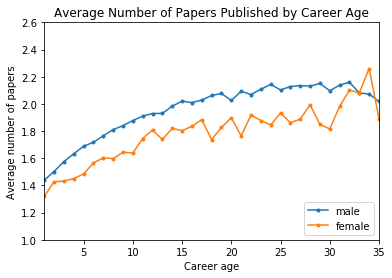

In [0]:
plt.figure(2)
plt.plot(pa_m, ave_m, '.-')
plt.plot(pa_fm, ave_fm, '.-')
plt.legend(['male', 'female'], loc='lower right')
plt.title('Average Number of Papers Published by Career Age')
plt.xlabel('Career age')
plt.ylabel('Average number of papers')
plt.xlim(1,35)
plt.ylim(1.00,2.60)

## 2. Productivity by Gender
Career age = last – first publication

Productivity = # publications / career age (normalizing)

Find ways to distinguish the formerly created productivity graph.


In [0]:
prod = data
prod = prod.groupby(['id', 'gender']).agg({'year':{'min_year':'min', 'max_year':'max', 'count':'count'}})
# prod.tail(n=20)

In [0]:
prod['career_age'] = prod['year']['max_year'] - prod['year']['min_year']
prod['prod'] = prod['year']['count'] / (prod['career_age'])

prod.sort_values([('year','count')], ascending=False).head()

In [0]:
print(len(prod))

In [0]:
prod_m = prod.xs('male', level='gender')
print(len(prod_m))
prod_m.head()

In [0]:
# prod_m = prod_m.groupby('career_age')['career_age'].count()

In [0]:
prod_m

In [0]:
# number of publications - male

x = prod_m['year']['count'].hist(bins=50)
x.set_yscale('log')
plt.title('Number of publications of APS male authors')
plt.xlabel('Number of publications')
plt.xlim(xmax=500)
plt.ylabel('log(count)')
plt.ylim(ymax=100000)

In [0]:
prod_fm = prod.xs('female', level='gender')
print(len(prod_fm))
prod_fm.head()

In [0]:
# number of publications - female

y = prod_fm['year']['count'].hist(bins=50, color='orange')
y.set_yscale('log')
plt.title('Number of publications of APS female authors')
plt.xlabel('Number of publications')
plt.xlim(xmax=500)
plt.ylabel('log(count)')
plt.ylim(ymax=100000)

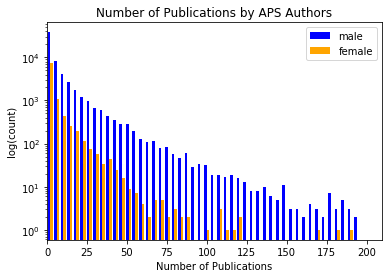

In [0]:
plt.style.use('seaborn-deep')

x = prod_m['year']['count']
y = prod_fm['year']['count']

bins = np.linspace(0, 200, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Number of Publications by APS Authors')
plt.xlabel('Number of Publications')
plt.xlim(xmin=0)
plt.ylabel('log(count)')
plt.show()

### 2b Test Run (w/o inf-s) & KS Test

In [0]:
prod_m2 = prod.xs('male', level='gender')
print(len(prod_m2))
prod_m2.head()

In [0]:
pmtest = prod_m2[prod_m2['career_age'] == 0]
print(len(pmtest))

In [0]:
prod_fm2 = prod.xs('female', level='gender')
print(len(prod_fm2))
prod_fm2.head()

In [0]:
pfmtest = prod_fm2[prod_fm2['career_age'] == 0]
print(len(pfmtest))

In [0]:
# del pmtest
# del pfmtest
prod_m2 = prod_m2[prod_m2['career_age'] != 0]
print(len(prod_m2))
prod_fm2 = prod_fm2[prod_fm2['career_age'] != 0]
print(len(prod_fm2))

In [0]:
x = prod_m2['year']['count'].hist(bins=50)
x.set_yscale('log')

In [0]:
y = prod_fm2['year']['count'].hist(bins=50)
y.set_yscale('log')

In [0]:
# productivity - male

x2 = prod_m2['prod'].hist(bins=100)
x2.set_yscale('log')
plt.title('Productivity of APS male authors')
plt.xlabel('Productivity')
plt.xlim(xmax=16)
plt.ylabel('log(count)')
plt.ylim(ymax=10000)

In [0]:
# productivity - female

y2 = prod_fm2['prod'].hist(bins=100, color='orange')
y2.set_yscale('log')
plt.title('Productivity of APS female authors')
plt.xlabel('Productivity')
plt.xlim(xmax=16)
plt.ylabel('log(count)')
plt.ylim(ymax=10000)

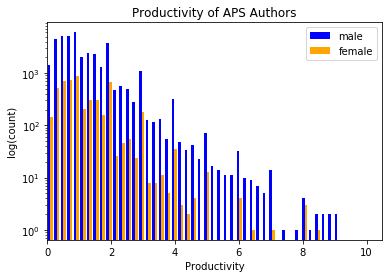

In [0]:
plt.style.use('seaborn-deep')

x = prod_m2['prod']
y = prod_fm2['prod']

# x = prod_m2['prod'].value_counts()
# y = prod_fm2['prod'].value_counts()
bins = np.linspace(0, 10, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Productivity of APS Authors')
plt.xlabel('Productivity')
plt.xlim(xmin=0)
plt.ylabel('log(count)')
plt.show()

Text(0, 0.5, 'Probability')

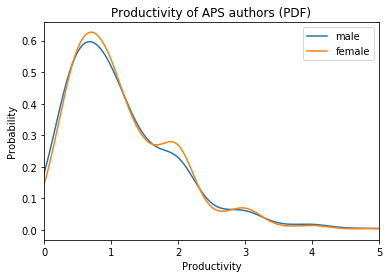

In [0]:
# PDF

xy_d = pd.DataFrame({'male': prod_m2['prod'], 'female': prod_fm2['prod']})
axy_d = xy_d.plot.kde(bw_method=0.3)
plt.title('Productivity of APS authors (PDF)')
plt.xlabel('Productivity')
plt.xlim(xmin=0, xmax=5)
plt.ylabel('Probability')

In [0]:
# CDF

import statsmodels.api as sm

sample = prod_m2['prod']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(x,y)

sample_2 = prod_fm2['prod']
ecdf = sm.distributions.ECDF(sample_2)

x_2 = np.linspace(min(sample_2), max(sample_2))
y_2 = ecdf(x_2)
plt.plot(x_2,y_2, color='orange')

plt.title('Productivity of APS authors (CDF)')
plt.legend(['male','female'], loc='lower right')
plt.xlabel('Productivity')
plt.xlim(xmin=0,xmax=4)
plt.ylabel('Probability')
plt.show()

In [0]:
data_m = prod_m2['prod']
data_fm = prod_fm2['prod']

sorted_data_m = np.sort(data_m)
sorted_data_fm = np.sort(data_fm)

yvals=np.arange(len(sorted_data_m))/float(len(sorted_data_m)-1)
yvals2=np.arange(len(sorted_data_fm))/float(len(sorted_data_fm)-1)

plt.plot(sorted_data_m,yvals)
plt.plot(sorted_data_fm,yvals2)

plt.title('Productivity of APS authors (CDF)')
plt.xlabel('Productivity')
plt.xlim(xmin=0.45, xmax=0.55)
plt.ylabel('Probability')
plt.ylim(ymin=0.15, ymax=0.25)

plt.show()

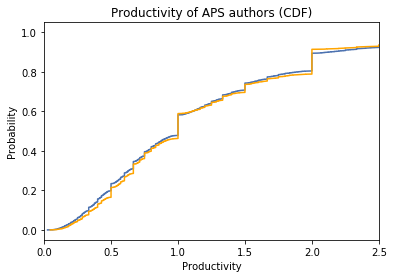

In [0]:
data_m = prod_m2['prod']
data_fm = prod_fm2['prod']

sorted_data_m = np.sort(data_m)
sorted_data_fm = np.sort(data_fm)

yvals=np.arange(len(sorted_data_m))/float(len(sorted_data_m)-1)
yvals2=np.arange(len(sorted_data_fm))/float(len(sorted_data_fm)-1)

plt.plot(sorted_data_m,yvals)
plt.plot(sorted_data_fm,yvals2, color='orange')

plt.title('Productivity of APS authors (CDF)')
plt.xlabel('Productivity')
plt.xlim(xmin=0, xmax=2.5)
plt.ylabel('Probability')
# plt.ylim(ymin=0, ymax=0.5)

plt.show()

In [0]:
#ks test

from scipy.stats import ks_2samp
ks_2samp(prod_m2['prod'], prod_fm2['prod'])

Ks_2sampResult(statistic=0.0329418537762845, pvalue=0.000127997328482532)

In [0]:
#ks test: m > fm

ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='greater')

Ks_2sampResult(statistic=0.0329418537762845, pvalue=6.244757804870422e-05)

In [0]:
pmhalf = prod_m2[prod_m2['prod'] >= 0.5]
pfmhalf = prod_fm2[prod_fm2['prod'] >= 0.5]

print(ks_2samp(pmhalf['prod'], pfmhalf['prod']))
print(ks_2samp(pmhalf['prod'], pfmhalf['prod'], alternative='greater'))
print(ks_2samp(pmhalf['prod'], pfmhalf['prod'], alternative='less'))

Ks_2sampResult(statistic=0.028984094069053334, pvalue=0.003998964540829228)
Ks_2sampResult(statistic=0.009776692159368938, pvalue=0.4894690513802622)
Ks_2sampResult(statistic=0.028984094069053334, pvalue=0.0019566232126424113)


In [0]:
#ks test: m < fm
ks_2samp(prod_m2['prod'], prod_fm2['prod'], alternative='less')

Ks_2sampResult(statistic=0.019882369577186365, pvalue=0.029229651385167425)

In [0]:
pmtwo = prod_m2[prod_m2['prod'] > 2]
pfmtwo = prod_fm2[prod_fm2['prod'] > 2]

print(ks_2samp(pmtwo['prod'], pfmtwo['prod']))
print(ks_2samp(pmtwo['prod'], pfmtwo['prod'], alternative='greater'))
print(ks_2samp(pmtwo['prod'], pfmtwo['prod'], alternative='less'))

Ks_2sampResult(statistic=0.11745518609742747, pvalue=3.535546159405545e-05)
Ks_2sampResult(statistic=0.11745518609742747, pvalue=1.8103332786473043e-05)
Ks_2sampResult(statistic=0.05037287903667214, pvalue=0.13140915393092845)


In [0]:
def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

# print(ks_2samp_x(prod_m2['prod'], prod_fm2['prod']))
# print(ks_2samp_x(prod_m2['prod'], prod_fm2['prod'], alternative="greater"))
# print(ks_2samp_x(prod_m2['prod'], prod_fm2['prod'], alternative="less"))

print(ks_2samp_x(pmtwo['prod'], pfmtwo['prod']))
print(ks_2samp_x(pmtwo['prod'], pfmtwo['prod'], alternative='greater'))
print(ks_2samp_x(pmtwo['prod'], pfmtwo['prod'], alternative='less'))

3.0434782608695654
2.9714285714285715
3.0434782608695654


## 3. Dropout Authors by Career Age
Don't include the authors who have not written anything before 1999.

(annual year is only showing less accurate dropout)

In [0]:
prod = data
prod = prod.groupby(['id', 'gender']).agg({'year':{'min_year':'min', 'max_year':'max', 'count':'count'}})

prod['career_age'] = prod['year']['max_year'] - prod['year']['min_year']
prod['prod'] = prod['year']['count'] / (prod['career_age'])

prod.sort_values([('year','count')], ascending=False).head()

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


year                career_age       prod
              min_year max_year count                      
id     gender                                              
162998 male       1961     2009   484         48  10.083333
92641  male       1979     2009   443         30  14.766667
145071 male       1978     2009   433         31  13.967742
233941 male       1958     2009   396         51   7.764706
140103 male       1983     2009   393         26  15.115385

In [0]:
drop = prod[prod['year']['min_year'] < 2004]
print(len(drop))
drop.head()

50292


year                career_age      prod
          min_year max_year count                     
id gender                                             
3  male       1985     1985     1          0       inf
7  male       1996     1999     2          3  0.666667
8  male       1991     1999     9          8  1.125000
9  male       1996     1996     1          0       inf
13 male       1989     2008    46         19  2.421053

In [0]:
# How many authors do not enter their second year?

one = drop[drop['career_age'] == 0]
print(len(one))

one_m = one.xs('male', level='gender')
print(len(one_m))

one_fm = one.xs('female', level='gender')
print(len(one_fm))

14743
12379
2364


In [0]:
# drop all the inf-s

drop = drop[drop['career_age'] > 0]
print(len(drop))
drop.head()

35549


year                career_age      prod
          min_year max_year count                     
id gender                                             
7  male       1996     1999     2          3  0.666667
8  male       1991     1999     9          8  1.125000
13 male       1989     2008    46         19  2.421053
15 male       1995     2002     9          7  1.285714
16 male       1993     2006     9         13  0.692308

In [0]:
old = drop[drop['career_age'] > 40]
print(len(old))

old_m = old.xs('male', level='gender')
print(len(old_m))

old_fm = old.xs('female', level='gender')
print(len(old_fm))

1054
992
62


In [0]:
gb = drop.groupby(['gender', 'career_age'])['career_age'].count()
n_m = gb['male'].sum()
n_fm = gb['female'].sum()
print(n_m, n_fm)
(gb['male']/n_m).plot()
(gb['female']/n_fm).plot()
t = np.linspace(1,70,1)
y = t^-(2/40)
plt.plot(t,y,'.-')

# plt.title()
# plt.xlim()
plt.yscale('log')

31667 3882


Text(0, 0.5, '% of Dropouts')

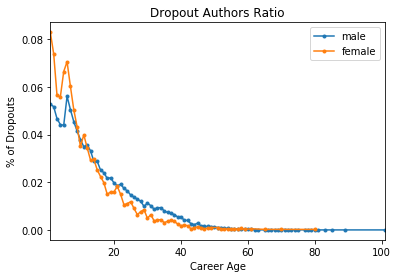

In [0]:
# scatterplot

gb = drop.groupby(['gender', 'career_age'])['career_age'].count()
n_m = gb['male'].sum()
n_fm = gb['female'].sum()
print(n_m, n_fm)

(gb['male']/n_m).plot(style='.-')
(gb['female']/n_fm).plot(style='.-')

# t = np.linspace(1,70)
# y = np.power(t,-(20/40))
# plt.plot(t,y-0.1, '--')

plt.title('Dropout Authors Ratio')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Career Age')
# plt.yscale('log')
plt.ylabel('% of Dropouts')

31667 3882


Text(0, 0.5, '% of Dropouts')

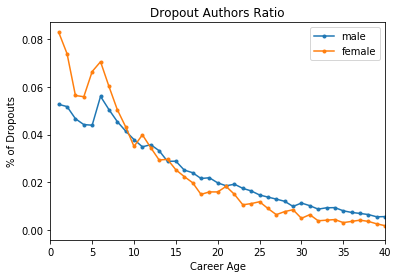

In [0]:
# scatterplot - edit

gb = drop.groupby(['gender', 'career_age'])['career_age'].count()
n_m = gb['male'].sum()
n_fm = gb['female'].sum()
print(n_m, n_fm)

(gb['male']/n_m).plot(style='.-')
(gb['female']/n_fm).plot(style='.-')

plt.title('Dropout Authors Ratio')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Career Age')
plt.xlim(0,40)
# plt.yscale('log')
plt.ylabel('% of Dropouts')

Text(0, 0.5, '% of Dropout')

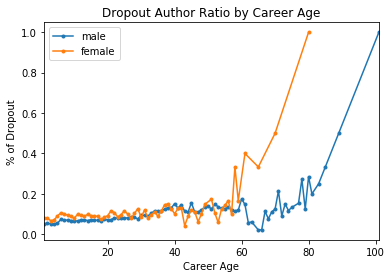

In [0]:
gb = drop.groupby(['gender', 'career_age'])['career_age'].count()
n_m = gb['male'].sum()
n_fm = gb['female'].sum()

gb_m = gb['male']
gb_fm = gb['female']

dropmale = gb_m.sort_index(ascending=False)
result_m = (dropmale / dropmale.cumsum()).iloc[::-1]

dropfemale = gb_fm.sort_index(ascending=False)
result_fm = (dropfemale / dropfemale.cumsum()).iloc[::-1]

result_m.plot(style='.-')
result_fm.plot(style='.-')

plt.title('Dropout Author Ratio by Career Age')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Career Age')
# plt.xlim(xmax=40)
plt.ylabel('% of Dropout')
# plt.ylim(ymin=0, ymax=0.2)

## 4. Frequently-cited Papers Analysis
Only consider primary authors.

How many of the top 10, 20, 30% belong to men first articles, female first articles?

Are those statistically significant? Expected?

If this is not expected, why? Productivity?

In [0]:
na = data[data['is_alpha'] == False]
print(len(na))
na.head()

503297


,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI
1,10.1103/PhysRev.5.269,127898,male,3,3,True,False,1915,article,PR
2,10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI


In [0]:
na['doi'].nunique()

252444

In [0]:
na_p = na[na['order'] == 1]
print(len(na_p))
print(na_p['doi'].nunique())
na_p.head()

149627
149627


,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI
6,10.1103/PhysRevSeriesI.27.225,159086,male,1,2,False,False,1908,article,PRI
7,10.1103/PhysRevSeriesI.4.314,29513,male,1,2,False,False,1897,article,PRI
8,10.1103/PhysRevSeriesI.5.152,29513,male,1,2,False,False,1897,article,PRI


In [0]:
plt.hist(np.log(np.unique(cb['cited_doi'].to_numpy(),return_counts=True)[1]), bins=100)

In [0]:
cb['cited_doi'].nunique()

357925

In [0]:
vc = cb['cited_doi'].value_counts()
# cb_sub = vc[vc.to_numpy() > 25].to_frame()
cb_sub = vc[vc.to_numpy() > 0].to_frame()
print(len(cb_sub))
print(cb_sub[:10])

357925
                             cited_doi
10.1103/PhysRev.140.A1133         5214
10.1103/PhysRev.136.B864          4100
10.1103/PhysRevLett.77.3865       3015
10.1103/PhysRevLett.45.566        2539
10.1103/PhysRevB.13.5188          2519
10.1103/PhysRevB.54.11169         2337
10.1103/PhysRevB.41.7892          1895
10.1103/PhysRevB.43.1993          1861
10.1103/PhysRev.108.1175          1679
10.1103/PhysRev.124.1866          1675


In [0]:
cited = pd.merge(cb_sub, na_p, left_index = True, right_on = 'doi')
print(len(cited))
cited.head()

128561


,cited_doi,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
202497,3015,10.1103/PhysRevLett.77.3865,45056,male,1,3,False,False,1996,article,PRL
91441,2519,10.1103/PhysRevB.13.5188,133666,male,1,2,False,False,1976,article,PRB
40415,2337,10.1103/PhysRevB.54.11169,132752,male,1,2,False,False,1996,article,PRB
40521,1364,10.1103/PhysRevB.47.558,157378,male,1,2,False,False,1993,rapid,PRB
217426,1354,10.1103/RevModPhys.57.287,182905,male,1,2,False,False,1985,article,RMP


In [0]:
cited_m = cited[cited['gender'] == 'male']
cited_fm = cited[cited['gender'] == 'female']

print(len(cited_m))
print(len(cited_fm))

118300
10261


In [0]:
cited_ten = cited[:12856]
print(len(cited_ten[cited_ten['gender'] == 'female']))

cited_tw = cited[:25712]
print(len(cited_tw[cited_tw['gender'] == 'female']))

cited_th = cited[:38568]
print(len(cited_th[cited_th['gender'] == 'female']))

cited_fo = cited[:51424]
print(len(cited_fo[cited_fo['gender'] == 'female']))

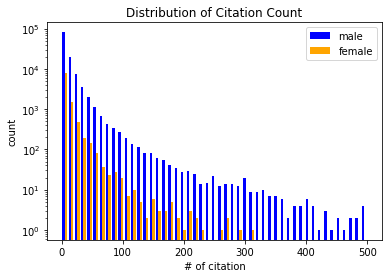

In [0]:
plt.style.use('seaborn-deep')

x = cited_m['cited_doi']
y = cited_fm['cited_doi']

bins = np.linspace(0, 500, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title("Distribution of Citation Count")
plt.xlabel('# of citation')
plt.ylabel('count')
# plt.xlim(xmin=0)
plt.show()

## 4b. Frequently-cited Papers Analysis 2

In [0]:
na = data[data['is_alpha'] == False]
na_p = na[na['order'] == 1]

vc = cb['cited_doi'].value_counts()
# cb_sub = vc[vc.to_numpy() > 25].to_frame()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

cited = pd.merge(cb_sub, na_p, left_index = True, right_on = 'doi')

cited_m = cited[cited['gender'] == 'male']
cited_fm = cited[cited['gender'] == 'female']

cited.head()

,cited_doi,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
202497,3015,10.1103/PhysRevLett.77.3865,45056,male,1,3,False,False,1996,article,PRL
91441,2519,10.1103/PhysRevB.13.5188,133666,male,1,2,False,False,1976,article,PRB
40415,2337,10.1103/PhysRevB.54.11169,132752,male,1,2,False,False,1996,article,PRB
40521,1364,10.1103/PhysRevB.47.558,157378,male,1,2,False,False,1993,rapid,PRB
217426,1354,10.1103/RevModPhys.57.287,182905,male,1,2,False,False,1985,article,RMP


In [0]:
cu = cited['cited_doi'].unique()
print(len(cu))
# cu.view()

395


In [0]:
print(cu[38])
print(cu[78])
print(cu[117])
print(cu[157])

511
346
288
243


In [0]:
print(len(cited_m[cited_m['cited_doi'] >= 511]))
print(len(cited_m[cited_m['cited_doi'] >= 346]))
print(len(cited_m[cited_m['cited_doi'] >= 288]))
print(len(cited_m[cited_m['cited_doi'] >= 243]))

39
89
149
220


In [0]:
print(len(cited_fm[cited_fm['cited_doi'] >= 511]))
print(len(cited_fm[cited_fm['cited_doi'] >= 346]))
print(len(cited_fm[cited_fm['cited_doi'] >= 288]))
print(len(cited_fm[cited_fm['cited_doi'] >= 243]))

1
1
3
6


In [0]:
len(cited[cited['gender'] == 'female'])/len(cited)

0.07981425160040759

Text(0, 0.5, 'Proportion of Female Primary Authors')

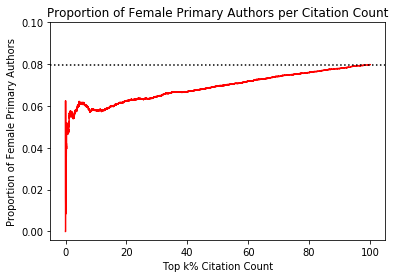

In [0]:
cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

plt.plot((np.arange(len(cited))*100)/len(cited), cumulate_cited_gender/np.arange(1, len(cited)+1), color='red')
plt.axhline(y=0.07981425160040759, color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Citation Count")
plt.xlabel("Top k% Citation Count")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")

## 5a. Self-citation Analysis (general)

In [0]:
print(len(cdata[cdata['citing_gender']=='male']))
print(len(cdata[cdata['citing_gender']=='female']))

8516293
867925


In [0]:
print(cdata['citing_id'].nunique())
print(cdata[cdata['citing_gender']=='male'].nunique())
print(cdata[cdata['citing_gender']=='female'].nunique())

68505
citing_doi       243699
citing_id         58888
citing_gender         1
cited_doi        214578
cited_id          59501
cited_gender          2
is_alpha              2
dtype: int64
citing_doi        39634
citing_id          9617
citing_gender         1
cited_doi        111940
cited_id          43558
cited_gender          2
is_alpha              2
dtype: int64


In [0]:
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
print(len(sc_list))
sc_list.head()

564360


,citing_doi,citing_id,citing_gender,citing_order,citing_numAuthor,citing_is_last,citing_is_alpha,citing_year,citing_articleType,citing_journal,citing_0,citing_1,citing_2,citing_3,citing_4,citing_5,citing_6,citing_7,citing_8,citing_9,citing_exceptions,cited_doi,cited_id,cited_gender,cited_order,cited_numAuthor,cited_is_last,cited_is_alpha,cited_year,cited_articleType,cited_journal,cited_0,cited_1,cited_2,cited_3,cited_4,cited_5,cited_6,cited_7,cited_8,cited_9,cited_exceptions
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI,False,False,False,False,False,False,False,False,False,False,[],10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI,False,False,False,False,False,False,False,False,False,False,[]
4,10.1103/PhysRev.61.339,212227,male,2,2,True,False,1942,article,PR,False,False,False,False,False,False,False,False,False,False,[],10.1103/PhysRev.59.575,212227,male,2,2,True,False,1941,article,PR,False,False,False,False,False,False,False,False,False,False,[]
5,10.1103/PhysRev.59.867,212227,male,2,2,True,False,1941,article,PR,False,False,False,False,False,False,False,False,False,False,[],10.1103/PhysRev.59.575,212227,male,2,2,True,False,1941,article,PR,False,False,False,False,False,False,False,False,False,False,[]
14,10.1103/PhysRev.60.535,212227,male,2,2,True,False,1941,letter-to-editor,PR,False,False,False,False,False,False,False,False,False,False,[],10.1103/PhysRev.59.575,212227,male,2,2,True,False,1941,article,PR,False,False,False,False,False,False,False,False,False,False,[]
88,10.1103/PhysRev.92.1367,9374,male,1,2,False,False,1953,article,PR,False,False,False,False,False,False,False,False,False,False,[],10.1103/PhysRev.91.174,9374,male,1,2,False,False,1953,article,PR,False,False,False,False,False,False,False,False,False,False,[]


In [0]:
sc_m = sc_list[sc_list['citing_gender'] == 'male']
print(len(sc_m))

sc_fm = sc_list[sc_list['citing_gender'] == 'female']
print(len(sc_fm))

524788
39572


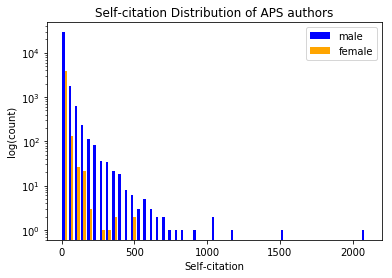

In [0]:
plt.style.use('seaborn-deep')

x = sc_m['citing_id'].value_counts()
y = sc_fm['citing_id'].value_counts()
bins = np.linspace(0, 2100, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Self-citation Distribution of APS authors')
plt.xlabel('Self-citation')
plt.ylabel('log(count)')
plt.show()

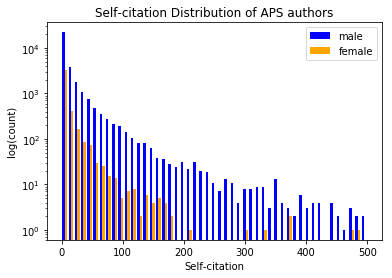

In [0]:
plt.style.use('seaborn-deep')

x = sc_m['citing_id'].value_counts()
y = sc_fm['citing_id'].value_counts()
bins = np.linspace(0, 500, 50)

plt.hist([x, y], bins, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Self-citation Distribution of APS authors')
plt.xlabel('Self-citation')
plt.ylabel('log(count)')
plt.show()

In [0]:
print(sc_m['citing_id'].nunique())
print(sc_fm['citing_id'].nunique())

31987
4083


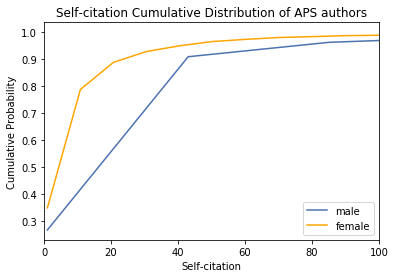

In [0]:
# CDF

import statsmodels.api as sm

sample = sc_m['citing_id'].value_counts()
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(x,y)

sample_2 = sc_fm['citing_id'].value_counts()
ecdf = sm.distributions.ECDF(sample_2)

x_2 = np.linspace(min(sample_2), max(sample_2))
y_2 = ecdf(x_2)
plt.plot(x_2,y_2, color='orange')

plt.title('Self-citation Cumulative Distribution of APS authors')
plt.legend(('male', 'female'), loc='lower right')
plt.xlabel('Self-citation')
plt.xlim(0,100)
plt.ylabel('Cumulative Probability')
# plt.ylim(0,0.35)
plt.show()

## 5b. Self-citation Analysis (by year)

In [0]:
sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

msc = sc_m.groupby(['citing_year'])['citing_year'].count()
fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()

n_m = len(sc_m)
n_fm = len(sc_fm)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.15)

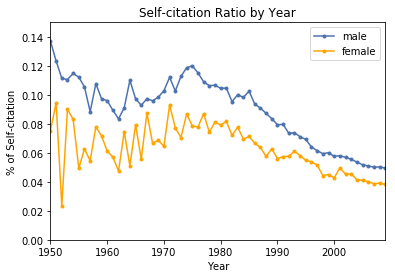

In [0]:
cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']

mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()

(msc/mcdata).plot(style='.-')
(fmsc/fmcdata).plot(style='.-',color='orange')

plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.15)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


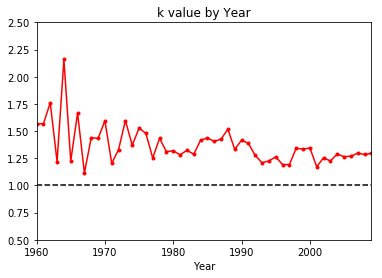

In [0]:
cdatacit = cdata.groupby(['citing_year'])['citing_year'].count()
cdatacit[np.isnan(cdatacit)] = 0

mcdata = cdata_m.groupby(['citing_year'])['citing_year'].count()
mcdata[np.isnan(mcdata)] = 0
fmcdata = cdata_fm.groupby(['citing_year'])['citing_year'].count()
fmcdata[np.isnan(fmcdata)] = 0

sccit = sc_list.groupby(['citing_year'])['citing_year'].count()
sccit[np.isnan(sccit)] = 0

msc = sc_m.groupby(['citing_year'])['citing_year'].count()
msc[np.isnan(msc)] = 0
fmsc = sc_fm.groupby(['citing_year'])['citing_year'].count()
fmsc[np.isnan(fmsc)] = 0

k1 = ((msc/sccit)/(fmsc/sccit))
k2 = ((fmcdata/cdatacit)/(mcdata/cdatacit))

k = k1*k2

k.plot(style='.-', color='red')

plt.title('k value by Year')
plt.xlabel('Year')
plt.xlim(xmin=1960)
# plt.ylabel('k')
plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2009,linestyles='dashed')

## 5c. Self-citation Analysis (by Author Number)

In [0]:
cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']

sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

564360
524788
39572


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


Text(0, 0.5, '% Self-citation')

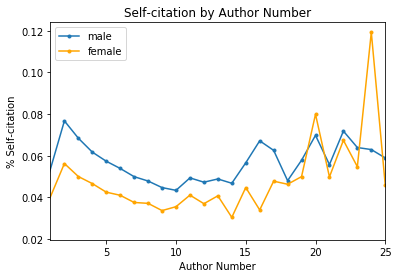

In [0]:
mcdata = cdata_m.groupby(['citing_numAuthor'])['citing_numAuthor'].count()
fmcdata = cdata_fm.groupby(['citing_numAuthor'])['citing_numAuthor'].count()

msc = sc_m.groupby(['citing_numAuthor'])['citing_numAuthor'].count()
fmsc = sc_fm.groupby(['citing_numAuthor'])['citing_numAuthor'].count()

(msc/mcdata).plot(style='.-')
(fmsc/fmcdata).plot(style='.-',color='orange')

plt.title('Self-citation by Author Number')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Author Number')
plt.xlim(xmin=1)
plt.ylabel('% Self-citation')

## 5d. Self-citation Analysis (by PACS & Year)

In [0]:
cdata_m = cdata[cdata['citing_gender'] == 'male']
cdata_fm = cdata[cdata['citing_gender'] == 'female']

sc_list = cdata[cdata['citing_id'] == cdata['cited_id']]
sc_m = sc_list[sc_list['citing_gender'] == 'male']
sc_fm = sc_list[sc_list['citing_gender'] == 'female']

In [0]:
cdata_m_0 = cdata_m[cdata_m['citing_0'] == True]
cdata_m_1 = cdata_m[cdata_m['citing_1'] == True]
cdata_m_2 = cdata_m[cdata_m['citing_2'] == True]
cdata_m_3 = cdata_m[cdata_m['citing_3'] == True]
cdata_m_4 = cdata_m[cdata_m['citing_4'] == True]
cdata_m_5 = cdata_m[cdata_m['citing_5'] == True]
cdata_m_6 = cdata_m[cdata_m['citing_6'] == True]
cdata_m_7 = cdata_m[cdata_m['citing_7'] == True]
cdata_m_8 = cdata_m[cdata_m['citing_8'] == True]
cdata_m_9 = cdata_m[cdata_m['citing_9'] == True]

cdata_fm_0 = cdata_fm[cdata_fm['citing_0'] == True]
cdata_fm_1 = cdata_fm[cdata_fm['citing_1'] == True]
cdata_fm_2 = cdata_fm[cdata_fm['citing_2'] == True]
cdata_fm_3 = cdata_fm[cdata_fm['citing_3'] == True]
cdata_fm_4 = cdata_fm[cdata_fm['citing_4'] == True]
cdata_fm_5 = cdata_fm[cdata_fm['citing_5'] == True]
cdata_fm_6 = cdata_fm[cdata_fm['citing_6'] == True]
cdata_fm_7 = cdata_fm[cdata_fm['citing_7'] == True]
cdata_fm_8 = cdata_fm[cdata_fm['citing_8'] == True]
cdata_fm_9 = cdata_fm[cdata_fm['citing_9'] == True]

sc_m_0 = sc_m[sc_m['citing_0'] == True]
sc_m_1 = sc_m[sc_m['citing_1'] == True]
sc_m_2 = sc_m[sc_m['citing_2'] == True]
sc_m_3 = sc_m[sc_m['citing_3'] == True]
sc_m_4 = sc_m[sc_m['citing_4'] == True]
sc_m_5 = sc_m[sc_m['citing_5'] == True]
sc_m_6 = sc_m[sc_m['citing_6'] == True]
sc_m_7 = sc_m[sc_m['citing_7'] == True]
sc_m_8 = sc_m[sc_m['citing_8'] == True]
sc_m_9 = sc_m[sc_m['citing_9'] == True]

sc_fm_0 = sc_fm[sc_fm['citing_0'] == True]
sc_fm_1 = sc_fm[sc_fm['citing_1'] == True]
sc_fm_2 = sc_fm[sc_fm['citing_2'] == True]
sc_fm_3 = sc_fm[sc_fm['citing_3'] == True]
sc_fm_4 = sc_fm[sc_fm['citing_4'] == True]
sc_fm_5 = sc_fm[sc_fm['citing_5'] == True]
sc_fm_6 = sc_fm[sc_fm['citing_6'] == True]
sc_fm_7 = sc_fm[sc_fm['citing_7'] == True]
sc_fm_8 = sc_fm[sc_fm['citing_8'] == True]
sc_fm_9 = sc_fm[sc_fm['citing_9'] == True]

mcdata_0 = cdata_m_0.groupby(['citing_year'])['citing_year'].count()
mcdata_1 = cdata_m_1.groupby(['citing_year'])['citing_year'].count()
mcdata_2 = cdata_m_2.groupby(['citing_year'])['citing_year'].count()
mcdata_3 = cdata_m_3.groupby(['citing_year'])['citing_year'].count()
mcdata_4 = cdata_m_4.groupby(['citing_year'])['citing_year'].count()
mcdata_5 = cdata_m_5.groupby(['citing_year'])['citing_year'].count()
mcdata_6 = cdata_m_6.groupby(['citing_year'])['citing_year'].count()
mcdata_7 = cdata_m_7.groupby(['citing_year'])['citing_year'].count()
mcdata_8 = cdata_m_8.groupby(['citing_year'])['citing_year'].count()
mcdata_9 = cdata_m_9.groupby(['citing_year'])['citing_year'].count()

fmcdata_0 = cdata_fm_0.groupby(['citing_year'])['citing_year'].count()
fmcdata_1 = cdata_fm_1.groupby(['citing_year'])['citing_year'].count()
fmcdata_2 = cdata_fm_2.groupby(['citing_year'])['citing_year'].count()
fmcdata_3 = cdata_fm_3.groupby(['citing_year'])['citing_year'].count()
fmcdata_4 = cdata_fm_4.groupby(['citing_year'])['citing_year'].count()
fmcdata_5 = cdata_fm_5.groupby(['citing_year'])['citing_year'].count()
fmcdata_6 = cdata_fm_6.groupby(['citing_year'])['citing_year'].count()
fmcdata_7 = cdata_fm_7.groupby(['citing_year'])['citing_year'].count()
fmcdata_8 = cdata_fm_8.groupby(['citing_year'])['citing_year'].count()
fmcdata_9 = cdata_fm_9.groupby(['citing_year'])['citing_year'].count()

msc_0 = sc_m_0.groupby(['citing_year'])['citing_year'].count()
msc_1 = sc_m_1.groupby(['citing_year'])['citing_year'].count()
msc_2 = sc_m_2.groupby(['citing_year'])['citing_year'].count()
msc_3 = sc_m_3.groupby(['citing_year'])['citing_year'].count()
msc_4 = sc_m_4.groupby(['citing_year'])['citing_year'].count()
msc_5 = sc_m_5.groupby(['citing_year'])['citing_year'].count()
msc_6 = sc_m_6.groupby(['citing_year'])['citing_year'].count()
msc_7 = sc_m_7.groupby(['citing_year'])['citing_year'].count()
msc_8 = sc_m_8.groupby(['citing_year'])['citing_year'].count()
msc_9 = sc_m_9.groupby(['citing_year'])['citing_year'].count()

fmsc_0 = sc_fm_0.groupby(['citing_year'])['citing_year'].count()
fmsc_1 = sc_fm_1.groupby(['citing_year'])['citing_year'].count()
fmsc_2 = sc_fm_2.groupby(['citing_year'])['citing_year'].count()
fmsc_3 = sc_fm_3.groupby(['citing_year'])['citing_year'].count()
fmsc_4 = sc_fm_4.groupby(['citing_year'])['citing_year'].count()
fmsc_5 = sc_fm_5.groupby(['citing_year'])['citing_year'].count()
fmsc_6 = sc_fm_6.groupby(['citing_year'])['citing_year'].count()
fmsc_7 = sc_fm_7.groupby(['citing_year'])['citing_year'].count()
fmsc_8 = sc_fm_8.groupby(['citing_year'])['citing_year'].count()
fmsc_9 = sc_fm_9.groupby(['citing_year'])['citing_year'].count()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

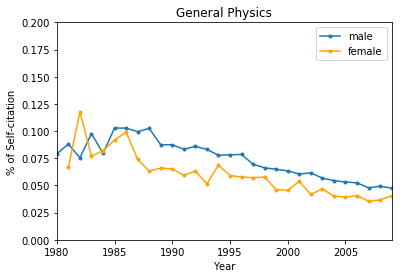

In [0]:
(msc_0/mcdata_0).plot(style='.-')
(fmsc_0/fmcdata_0).plot(style='.-',color='orange')

plt.title('General Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

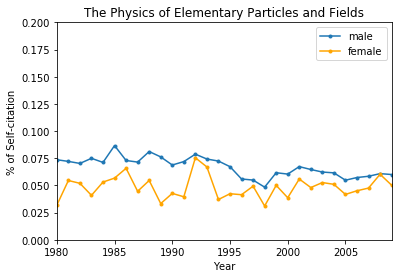

In [0]:
(msc_1/mcdata_1).plot(style='.-')
(fmsc_1/fmcdata_1).plot(style='.-',color='orange')

plt.title('The Physics of Elementary Particles and Fields')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

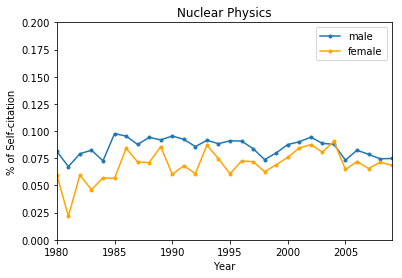

In [0]:
(msc_2/mcdata_2).plot(style='.-')
(fmsc_2/fmcdata_2).plot(style='.-',color='orange')

plt.title('Nuclear Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

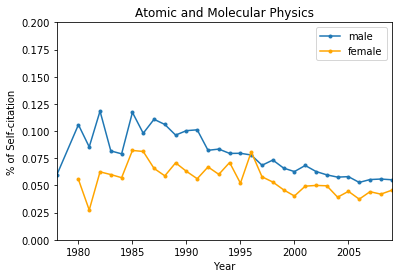

In [0]:
(msc_3/mcdata_3).plot(style='.-')
(fmsc_3/fmcdata_3).plot(style='.-',color='orange')

plt.title('Atomic and Molecular Physics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

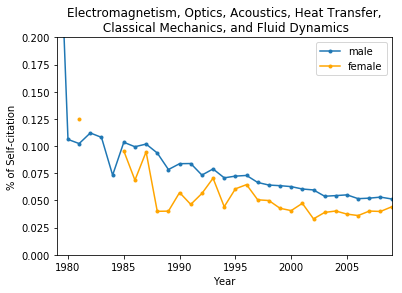

In [0]:
(msc_4/mcdata_4).plot(style='.-')
(fmsc_4/fmcdata_4).plot(style='.-',color='orange')

plt.title('Electromagnetism, Optics, Acoustics, Heat Transfer,\n Classical Mechanics, and Fluid Dynamics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

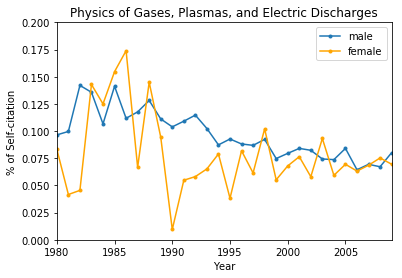

In [0]:
(msc_5/mcdata_5).plot(style='.-')
(fmsc_5/fmcdata_5).plot(style='.-',color='orange')

plt.title('Physics of Gases, Plasmas, and Electric Discharges')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

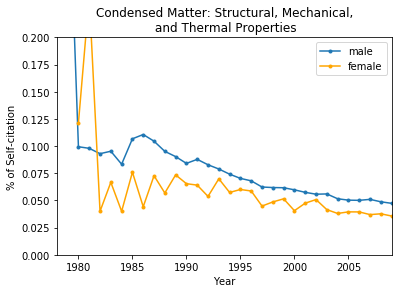

In [0]:
(msc_6/mcdata_6).plot(style='.-')
(fmsc_6/fmcdata_6).plot(style='.-',color='orange')

plt.title('Condensed Matter: Structural, Mechanical,\n and Thermal Properties')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

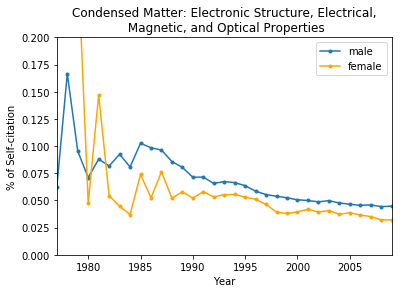

In [0]:
(msc_7/mcdata_7).plot(style='.-')
(fmsc_7/fmcdata_7).plot(style='.-',color='orange')

plt.title('Condensed Matter: Electronic Structure, Electrical,\n Magnetic, and Optical Properties')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

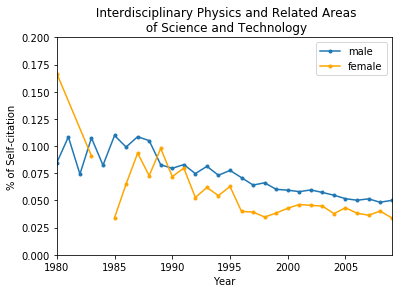

In [0]:
(msc_8/mcdata_8).plot(style='.-')
(fmsc_8/fmcdata_8).plot(style='.-',color='orange')

plt.title('Interdisciplinary Physics and Related Areas\n of Science and Technology')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 0.2)

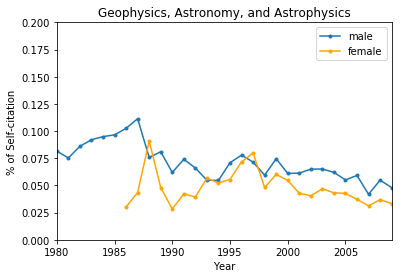

In [0]:
(msc_9/mcdata_9).plot(style='.-')
(fmsc_9/fmcdata_9).plot(style='.-',color='orange')

plt.title('Geophysics, Astronomy, and Astrophysics')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
# plt.xlim(xmin=1950)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.2)

In [0]:
del cdata_m_0
del cdata_m_1
del cdata_m_2
del cdata_m_3
del cdata_m_4
del cdata_m_5
del cdata_m_6
del cdata_m_7
del cdata_m_8
del cdata_m_9

del cdata_fm_0
del cdata_fm_1
del cdata_fm_2
del cdata_fm_3
del cdata_fm_4
del cdata_fm_5
del cdata_fm_6
del cdata_fm_7
del cdata_fm_8
del cdata_fm_9

del sc_m_0
del sc_m_1
del sc_m_2
del sc_m_3
del sc_m_4
del sc_m_5
del sc_m_6
del sc_m_7
del sc_m_8
del sc_m_9

del sc_fm_0
del sc_fm_1
del sc_fm_2
del sc_fm_3
del sc_fm_4
del sc_fm_5
del sc_fm_6
del sc_fm_7
del sc_fm_8
del sc_fm_9

del mcdata_0
del mcdata_1
del mcdata_2
del mcdata_3
del mcdata_4
del mcdata_5
del mcdata_6
del mcdata_7
del mcdata_8
del mcdata_9

del fmcdata_0
del fmcdata_1
del fmcdata_2
del fmcdata_3
del fmcdata_4
del fmcdata_5
del fmcdata_6
del fmcdata_7
del fmcdata_8
del fmcdata_9

del msc_0
del msc_1
del msc_2
del msc_3
del msc_4
del msc_5
del msc_6
del msc_7
del msc_8
del msc_9

del fmsc_0
del fmsc_1
del fmsc_2
del fmsc_3
del fmsc_4
del fmsc_5
del fmsc_6
del fmsc_7
del fmsc_8
del fmsc_9

## 6 PageRank Centrality

In [0]:
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi', target='cited_doi', create_using=Graphtype)
# print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [0]:
pr = nx.pagerank(C)
print(len(pr))

prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()
prs.head()

144813


,doi,centrality
0,10.1103/PhysRevB.1.3614,0.000002
1,10.1103/PhysRev.91.174,0.000078
2,10.1103/PhysRev.92.1367,0.000018
3,10.1103/RevModPhys.62.251,0.000305
4,10.1103/PhysRevA.10.1494,0.000040


In [0]:
nodedata = data[data['is_alpha'] == False]
nodedata = nodedata[nodedata['order'] == 1]
nodedata = nodedata.drop(['order', 'numAuthor',	'is_last',	'is_alpha',	'year',	'articleType',	'journal', 'id'], axis=1)
nodedata = nodedata.reset_index()
nodedata.columns = ['id', 'Label', 'Gender']
nodedata.head()

prs = prs.merge(nodedata, left_on='doi', right_on='Label', how='left')
prs = prs.drop(['doi', 'Label'], axis=1)
prs = prs[['id', 'Gender', 'centrality']]

prs.head()

,id,Gender,centrality
0,2327,female,0.000002
1,102128,male,0.000078
2,102129,male,0.000018
3,29386,male,0.000305
4,41171,male,0.000040


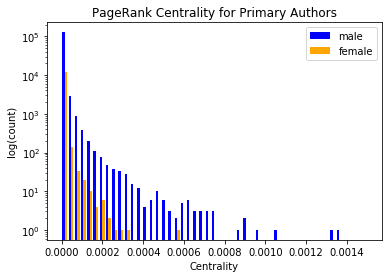

In [0]:
prs_m = prs[prs['Gender'] == 'male']
prs_fm = prs[prs['Gender'] == 'female']

plt.style.use('seaborn-deep')
bins = np.linspace(0, 0.0015, 50)

plt.hist([prs_m['centrality'], prs_fm['centrality']], bins, label=['male', 'female'], color=['blue','orange'])

plt.title("PageRank Centrality for Primary Authors")
plt.legend(loc='upper right')
plt.xlabel('Centrality')
plt.yscale('log')
plt.ylabel('log(count)')
plt.show()

In [0]:
prs = prs.sort_values('centrality', ascending=False)
prs.head()

,id,Gender,centrality
3189,43633,male,0.001368
25816,87360,male,0.001325
49819,187598,male,0.001062
54770,187575,male,0.000961
20116,91551,male,0.000918


Text(0, 0.5, 'Proportion of Female Primary Authors')

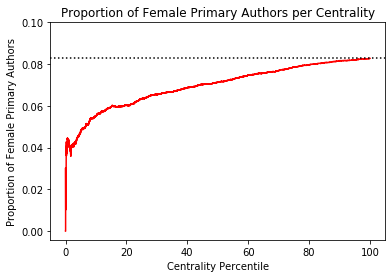

In [0]:
prs_gender = prs['Gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

plt.plot((np.arange(len(prs))*100)/len(prs), cumulate_prs_gender/np.arange(1, len(prs)+1), color='red')
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Centrality")
plt.xlabel("top k% Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")